In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, precision_score, recall_score, f1_score, accuracy_score

In [216]:
PARQUETS_PATH = 'results/'
TEST_RATIO = 0.2
VALIDATION_RATIO = 0.1

AUTO_TUNE = True

FEATURE_LIST = [
    'previous_price_1min',
    'previous_price_5min',
    'previous_price_10min',
    'previous_price_15min',
    'previous_price_20min',
    'previous_price_25min',
    'previous_price_30min',
    'previous_price_35min',
    'previous_price_40min',
    'previous_price_45min',
    'previous_price_50min',
    'previous_price_55min',
    'previous_price_60min',
    'open',
    'std_30min',
    'max_30min',
    'min_30min',
    'mean_30min',
]

In [217]:
data_df = pd.read_parquet(PARQUETS_PATH)
data_df

,time,open,high,low,close,volume
0,2023-08-16 03:00:13.599,29200.00,29200.01,29200.00,29200.00,200
1,2023-08-16 03:00:29.747,29200.00,29200.01,29196.21,29196.42,200
2,2023-08-16 03:01:10.681,29196.42,29196.42,29196.41,29196.41,200
3,2023-08-16 03:01:31.331,29196.41,29201.06,29196.41,29201.06,200
4,2023-08-16 03:02:11.888,29201.09,29202.00,29201.09,29201.99,200
...,...,...,...,...,...,...
25522,2023-08-21 02:55:45.377,26178.80,26179.99,26178.80,26179.99,200
25523,2023-08-21 02:56:09.506,26179.99,26188.88,26179.99,26188.87,200
25524,2023-08-21 02:57:36.989,26188.88,26190.00,26188.88,26190.00,200
25525,2023-08-21 02:58:50.507,26189.99,26190.00,26189.99,26190.00,200


In [218]:
def calculate_rsi(data, window):
    diff = data['close'].diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_window = 30  # You can adjust this window size as needed


In [219]:
def add_feature(data_df):

    data_df['target'] = data_df['close'].shift(-1) - data_df['close']
    data_df['open_diff'] = data_df['open'].shift(-1) - data_df['open']

    for i in range(1, 13):
        data_df[f'previous_price_{i*5}min'] = data_df['target'].shift(i*5)
        data_df[f'previous_price_{i*5}min_open'] = data_df['open_diff'].shift(i*5)
    data_df['previous_price_1min'] = data_df['target'].shift(1)
    data_df['previous_price_1min_open'] = data_df['open_diff'].shift(1)
    
    data_df['max_30min'] = data_df['close'].shift(1).rolling(window=6*5).max()
    data_df['min_30min'] = data_df['close'].shift(1).rolling(window=6*5).min()
    data_df['mean_30min'] = data_df['close'].shift(1).rolling(window=6*5).mean()
    data_df['std_30min'] = data_df['close'].shift(1).rolling(window=6*5).std()

    data_df['EMA'] = data_df['close'].ewm(span=30, adjust=False).mean()
    data_df['RSI'] = calculate_rsi(data_df, rsi_window)

    data_df['signal'] = (data_df['target'] > 0).apply(lambda x: int(x))
    
    return data_df

In [220]:
feature_df = add_feature(data_df)
feature_df.dropna(inplace=True)
feature_df

,time,open,high,low,close,volume,target,open_diff,previous_price_5min,previous_price_5min_open,...,previous_price_60min_open,previous_price_1min,previous_price_1min_open,max_30min,min_30min,mean_30min,std_30min,EMA,RSI,signal
60,2023-08-16 03:40:13.187,29200.49,29202.04,29200.49,29202.03,200,0.00,1.54,-0.62,-3.11,...,0.00,1.54,0.01,29237.27,29200.48,29216.845000,9.836456,29212.529604,8.087536,0
61,2023-08-16 03:40:55.170,29202.03,29202.04,29202.03,29202.03,200,0.01,0.00,-2.12,-0.61,...,-3.58,0.00,1.54,29237.27,29200.48,29215.670333,9.408046,29211.852210,8.087536,1
62,2023-08-16 03:41:44.979,29202.03,29202.04,29202.03,29202.04,200,0.00,0.01,-3.40,-2.13,...,-0.01,0.01,0.00,29236.00,29200.48,29214.495667,8.798406,29211.219164,8.361942,0
63,2023-08-16 03:42:19.476,29202.04,29202.04,29202.03,29202.04,200,1.17,0.00,0.01,-3.39,...,4.68,0.00,0.01,29235.54,29200.48,29213.363667,8.092592,29210.626960,8.457341,1
64,2023-08-16 03:42:34.985,29202.04,29203.21,29202.04,29203.21,200,0.00,1.17,1.54,0.01,...,0.90,1.17,0.00,29228.09,29200.48,29212.247000,7.187725,29210.148447,13.454759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25521,2023-08-21 02:54:10.531,26178.80,26178.80,26178.79,26178.80,200,1.19,0.00,-1.74,6.06,...,-0.13,0.00,3.29,26188.77,26154.56,26173.147000,10.128673,26173.823992,59.836066,1
25522,2023-08-21 02:55:45.377,26178.80,26179.99,26178.80,26179.99,200,8.88,1.19,-6.25,-1.99,...,-4.90,1.19,0.00,26188.77,26154.56,26173.955000,9.544821,26174.221799,60.220240,1
25523,2023-08-21 02:56:09.506,26179.99,26188.88,26179.99,26188.87,200,1.13,8.89,5.50,-6.27,...,-6.91,8.88,1.19,26188.77,26154.86,26174.802667,8.868199,26175.166844,62.786676,1
25524,2023-08-21 02:57:36.989,26188.88,26190.00,26188.88,26190.00,200,0.00,1.11,3.29,5.51,...,0.83,1.13,8.89,26188.87,26156.57,26175.936333,8.391966,26176.123822,60.784469,0


In [221]:
def train_test_splitting(dataset, split_ratio):

    train_len = int((1 - split_ratio) * len(dataset))
    train_df = dataset[:train_len]
    test_df = dataset[train_len:]

    return train_df, test_df

In [222]:
train_df, test_df = train_test_splitting(feature_df, TEST_RATIO)

In [223]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_RATIO) 

In [224]:
print(f'train dataframe shape : {train_df.shape}')
print(f'train dataframe shape : {test_df.shape}')
print(f'train dataframe shape : {valid_df.shape}')
train_df.head()

train dataframe shape : (20372, 41)
train dataframe shape : (5094, 41)
train dataframe shape : (2038, 41)


,time,open,high,low,close,volume,target,open_diff,previous_price_5min,previous_price_5min_open,...,previous_price_60min_open,previous_price_1min,previous_price_1min_open,max_30min,min_30min,mean_30min,std_30min,EMA,RSI,signal
60,2023-08-16 03:40:13.187,29200.49,29202.04,29200.49,29202.03,200,0.00,1.54,-0.62,-3.11,...,0.00,1.54,0.01,29237.27,29200.48,29216.845000,9.836456,29212.529604,8.087536,0
61,2023-08-16 03:40:55.170,29202.03,29202.04,29202.03,29202.03,200,0.01,0.00,-2.12,-0.61,...,-3.58,0.00,1.54,29237.27,29200.48,29215.670333,9.408046,29211.852210,8.087536,1
62,2023-08-16 03:41:44.979,29202.03,29202.04,29202.03,29202.04,200,0.00,0.01,-3.40,-2.13,...,-0.01,0.01,0.00,29236.00,29200.48,29214.495667,8.798406,29211.219164,8.361942,0
63,2023-08-16 03:42:19.476,29202.04,29202.04,29202.03,29202.04,200,1.17,0.00,0.01,-3.39,...,4.68,0.00,0.01,29235.54,29200.48,29213.363667,8.092592,29210.626960,8.457341,1
64,2023-08-16 03:42:34.985,29202.04,29203.21,29202.04,29203.21,200,0.00,1.17,1.54,0.01,...,0.90,1.17,0.00,29228.09,29200.48,29212.247000,7.187725,29210.148447,13.454759,0


In [225]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_score = 0

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        current_model.fit(train_df[feature_list], train_df['signal'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_score = precision_score(val_df['signal'], y_val_pred)
        
        if val_score > best_val_score:
            best_val_score = val_score
            best_params = current_params
    
    return best_params, best_val_score

In [226]:
if AUTO_TUNE:
    params_test = {
                    'bootstrap' : [True], 
                    'max_depth' : [6, 7, 8, 9, 10], 
                    'min_samples_leaf' : [2, 5, 10, 15, 20], 
                    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8], 
                    'n_jobs' : [-1], 
                    'n_estimators' : [300], 
                    'oob_score' : [True]
                  }


    best_params, best_score = grid_search(
        model_class = RandomForestClassifier, 
        param_grid = params_test,
        train_df = grid_search_train_df, 
        val_df = valid_df,
        feature_list = FEATURE_LIST, 
        )
    
    print(best_params, best_score)
else:
    best_params = {
                    'bootstrap': True, 
                    'max_depth': 7, 
                    'min_samples_leaf': 15, 
                    'max_features': 0.6, 
                    'n_jobs': -1, 
                    'n_estimators': 300, 
                    'oob_score': True
                  }
    
    

{'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 2, 'max_features': 0.8, 'n_jobs': -1, 'n_estimators': 300, 'oob_score': True} 0.5578562728380024


In [227]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['signal'])

    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [228]:
model = RandomForestClassifier(**best_params)
train_prediction_df , test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

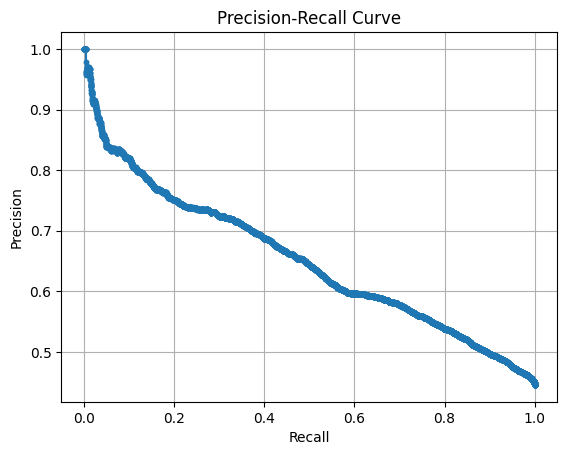

In [229]:
prediction_probs = model.predict_proba(train_df[FEATURE_LIST])
precision, recall, thresholds = precision_recall_curve(train_df['signal'], prediction_probs[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [230]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [231]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(precision_score, 'precision_score', train_data['signal'], train_prediction_df)
    evaluate(recall_score, 'recall_score', train_data['signal'], train_prediction_df)
    evaluate(accuracy_score, 'accuracy_score', train_data['signal'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(precision_score, 'precision_score', test_data['signal'], test_prediction_df)
    evaluate(recall_score, 'recall_score', test_data['signal'], test_prediction_df)
    evaluate(accuracy_score, 'accuracy_score', test_data['signal'], test_prediction_df)


In [232]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
precision_score : 0.6102799227799228
recall_score : 0.5572939620978404
accuracy_score : 0.6442175535048105

Ridge Regression test scores:
precision_score : 0.5882352941176471
recall_score : 0.4963937208315656
accuracy_score : 0.6062033765213978


C:\Users\bardia\AppData\Local\Temp\ipykernel_20452\3330557461.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


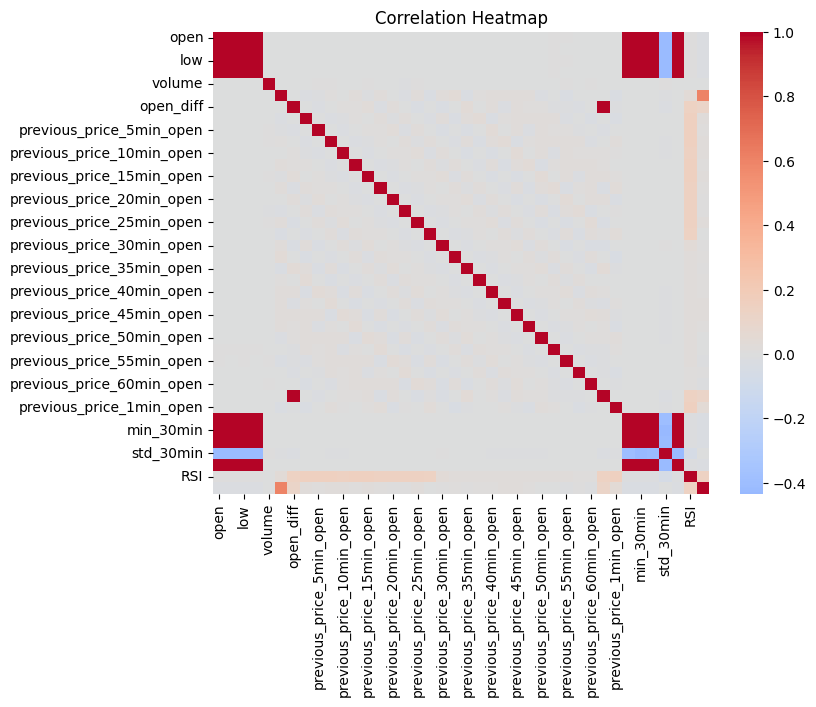

In [233]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()